# Prediction 

Heart segmentation model loaded successfully
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


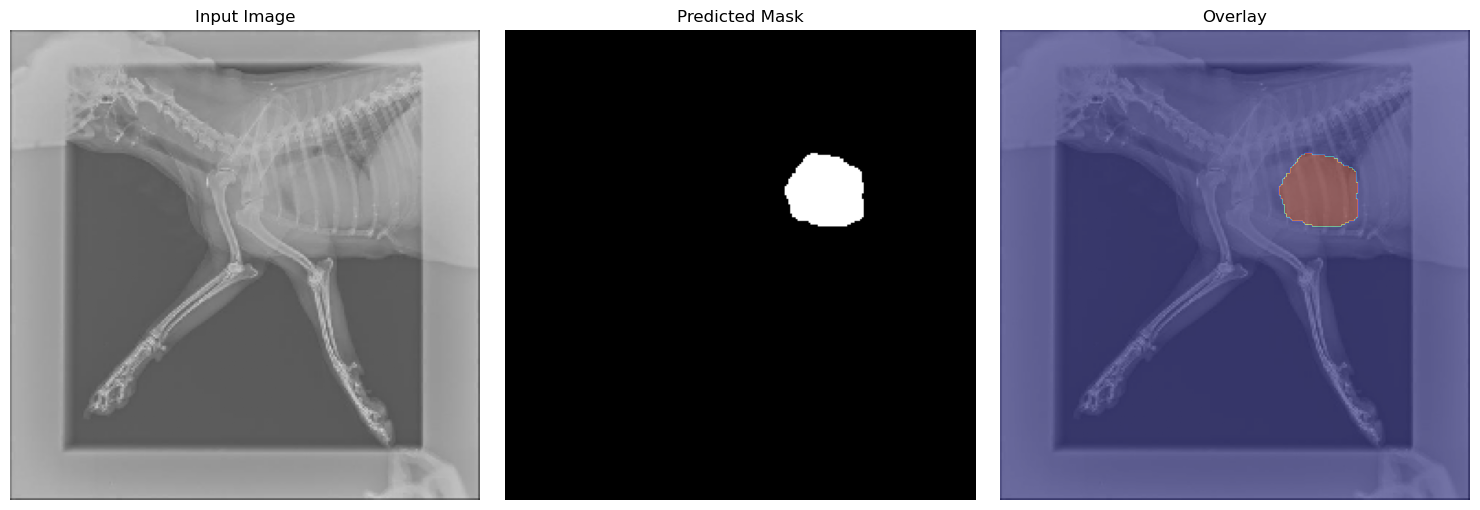


image 1/1 /Users/armandbryan/Documents/aivancity/PGE5/Medical AI/processed datas/veterinary_heart_vert_detection.v1i.coco/valid/I0000186_jpeg.rf.ab0635c243302439a5705fbc83d950a2.jpg: 640x640 5 vertebres, 87.8ms
Speed: 1.0ms preprocess, 87.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


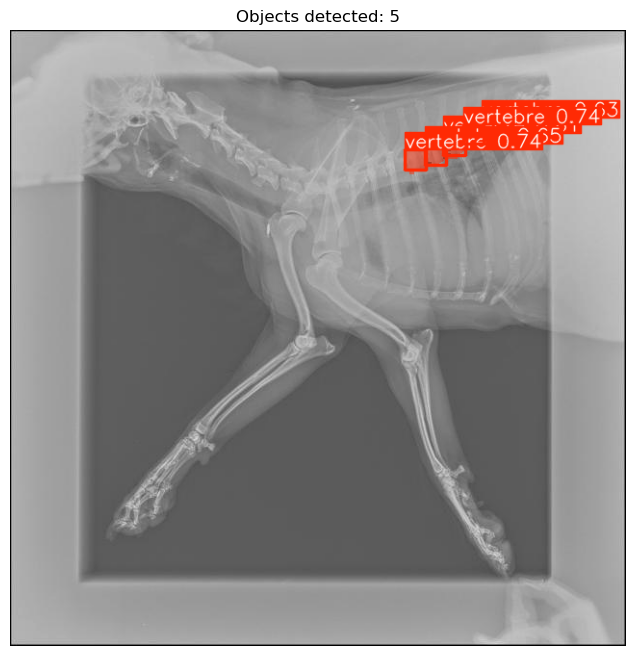

Vertebra 1: Length = 20.24 pixels
Vertebra 2: Length = 21.59 pixels
Vertebra 3: Length = 21.65 pixels
Vertebra 4: Length = 18.79 pixels
Vertebra 5: Length = 22.96 pixels


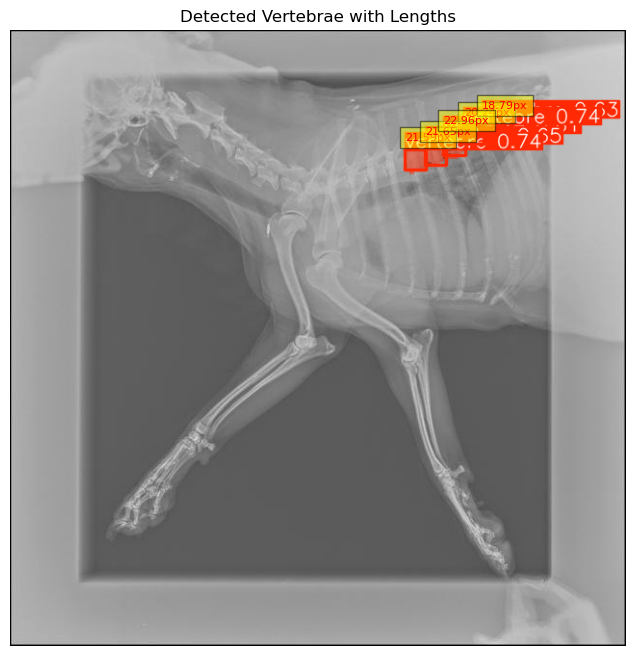

In [1]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from ultralytics import YOLO
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Define paths for the YOLO model, segmentation model, and input image
path_yolo = "/Users/armandbryan/Documents/aivancity/PGE5/Medical AI/Project/saves/yolo_logs/weights/best.pt"
image_path = "/Users/armandbryan/Documents/aivancity/PGE5/Medical AI/processed datas/veterinary_heart_vert_detection.v1i.coco/valid/I0000186_jpeg.rf.ab0635c243302439a5705fbc83d950a2.jpg"
heart_model_path = '/Users/armandbryan/Documents/aivancity/PGE5/Medical AI/models/heart_segmentation_model.h5'

# Load the U-Net heart segmentation model
heart_model = tf.keras.models.load_model(heart_model_path)
print('Heart segmentation model loaded successfully')

# Load and preprocess the input image for the U-Net model
img_size = (256, 256)
new_image = load_img(image_path, target_size=img_size)
new_image = img_to_array(new_image) / 255.0 
new_image = np.expand_dims(new_image, axis=0)  

# Predict the mask using the segmentation model
prediction = heart_model.predict(new_image)
predicted_mask = (prediction > 0.5).astype(np.uint8)

# Save the predicted mask as an image file
predicted_mask_image = predicted_mask[0, :, :, 0] * 255  
cv2.imwrite('predicted_mask.png', predicted_mask_image)

# Create a figure with multiple subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the input image
axes[0].imshow(new_image[0])
axes[0].set_title('Input Image')
axes[0].axis('off')

# Plot the predicted mask
axes[1].imshow(predicted_mask_image, cmap='gray')
axes[1].set_title('Predicted Mask')
axes[1].axis('off')

# Plot the overlay of the mask on the input image
axes[2].imshow(new_image[0], cmap='gray')
axes[2].imshow(predicted_mask_image, cmap='jet', alpha=0.4)  # Overlay the mask with transparency
axes[2].set_title('Overlay')
axes[2].axis('off')
plt.tight_layout()
plt.savefig("/Users/armandbryan/Documents/aivancity/PGE5/Medical AI/Project/saves/images/outputs/unet-heart-detection-combined.png", dpi=300, bbox_inches='tight')
plt.show()

# Load the YOLO model
yolo = YOLO(path_yolo)
# Perform object detection using YOLO with a confidence threshold of 0.6
results = yolo.predict(image_path, conf=0.6)
# Annotate the detected objects on the input image
annotated_image = results[0].plot()

# Create a figure for YOLO output
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title(f"Objects detected: {len(results[0].boxes)}")  # Display number of detected objects
ax.imshow(annotated_image)
ax.axis("off")
plt.savefig("/Users/armandbryan/Documents/aivancity/PGE5/Medical AI/Project/saves/images/outputs/yolo-vertebrae-detection.png", dpi=300, bbox_inches='tight')
plt.show()

# Extract the bounding boxes and compute the lengths
vertebra_lengths = []
for box in results[0].boxes:
    x1, y1, x2, y2 = box.xyxy[0].tolist()  # Get bounding box coordinates (x1, y1, x2, y2)
    length = y2 - y1  # Calculate the length of the vertebra (height of the bounding box)
    vertebra_lengths.append(length)

# Display the lengths of each detected vertebra
for idx, length in enumerate(vertebra_lengths, 1):
    print(f"Vertebra {idx}: Length = {length:.2f} pixels")

annotated_image = results[0].plot()
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(annotated_image)
ax.set_title("Detected Vertebrae with Lengths")
ax.axis("off")

for idx, box in enumerate(results[0].boxes):
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    length = vertebra_lengths[idx]
    ax.text(x1, y1 - 10, f"{length:.2f}px", color="red", fontsize=8, bbox=dict(facecolor='yellow', alpha=0.5))

plt.savefig("/Users/armandbryan/Documents/aivancity/PGE5/Medical AI/Project/saves/images/outputs/yolo-vertebrae-lengths.png", dpi=300, bbox_inches='tight')
plt.show()